# Capstone Machine Learning Algorithm Creation

In [1]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt

In [2]:
database = "group3-DB"
table = "dbo.hstock"
user = "group3_user"
password  = "K-qC4SoI_oUvepg"
server = "gen10-data-fundamentals-21-11-sql-server.database.windows.net"

Load in table from SQL using variables above

In [3]:
#read table data into a spark dataframe
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()
query = f"SELECT * FROM {table}"
hst_df = pd.read_sql(query, conn)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Dataframe sorting

In [4]:
apple_df = hst_df[hst_df['Ticker'] == 'AAPL']
apple_df = apple_df.drop(columns = 'Ticker')
apple_df['Date'] = pd.to_datetime(apple_df['Date'], format='%Y-%m-%d')
apple_df.sort_values('Date', inplace=True)
apple_df = apple_df[apple_df['Date'] >= '2021-01-01']
apple_df.reset_index(drop=True, inplace=True)
apple_df

,Date,Open,High,Low,Close,Volume
0,2021-01-04,133.52,133.6116,126.760,129.41,143301887
1,2021-01-05,128.89,131.7400,128.430,131.01,97664898
2,2021-01-06,127.72,131.0499,126.382,126.60,155087970
3,2021-01-07,128.36,131.6300,127.860,130.92,109578157
4,2021-01-08,132.43,132.6300,130.230,132.05,105158245
...,...,...,...,...,...,...
276,2022-02-07,172.86,173.9458,170.950,171.66,77251204
277,2022-02-08,171.73,175.3500,171.430,174.83,74829217
278,2022-02-09,176.05,176.6500,174.900,176.28,71285038
279,2022-02-10,174.14,175.4800,171.550,172.12,90865899


### AR Model Stuff

Create an autoregressive model which uses the High price of Apple stock

Autoregressive (AR) Models create predictions of points by using previous points in the time series. The simplicity of the model lies in the fact that typically only uses the dependent variable to make predictions, and it only has one hyperparameter which controls the number of previous points used in prediction. This hyperparameter is often referred to as the order or lag of the model.

In [5]:
m_df = apple_df.drop(columns=['Date', 'Open', 'Close', 'Low', 'Volume'])

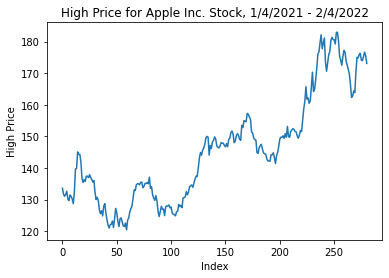

In [6]:
plt.plot(m_df['High'])

plt.ylabel('High Price')
plt.xlabel('Index')
plt.title('High Price for Apple Inc. Stock, 1/4/2021 - 2/4/2022')
plt.show()

Training/Test Split

We split our data up in order to make predictions on known data and check the accuracy of our model.

In [7]:
ar_test_data = m_df.iloc[-15:]
ar_train_data = m_df.iloc[:-15]

ADFuller test

This test allows us to determine if there is a unit root in the data which would interfere with our machine learning process.

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(m_df['High'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -0.7435691142374475,
 'pvalue': 0.8351391742777452,
 'usedlag': 1,
 'nobs': 279,
 'criticalvalues': {'1%': -3.4540076534999957,
  '5%': -2.8719557347997178,
  '10%': -2.5723200648758366},
 'icbest': 1117.3359558593318}

The pvalue for this test indicates that we may need to take the difference of subsequent values in order to effectively locate the correct lag value(s)

In [9]:
m_df['Diff'] = m_df['High'] - m_df['High'].shift(1)

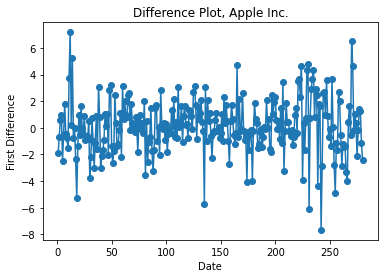

In [10]:
plt.plot(m_df['Diff'], marker='o')

plt.ylabel('First Difference')
plt.xlabel('Date')
plt.title('Difference Plot, Apple Inc.')
plt.show()

In [11]:
result = adfuller(m_df['Diff'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -14.58778610669558,
 'pvalue': 4.363550532794364e-27,
 'usedlag': 0,
 'nobs': 279,
 'criticalvalues': {'1%': -3.4540076534999957,
  '5%': -2.8719557347997178,
  '10%': -2.5723200648758366},
 'icbest': 1110.9389651281479}

By these results, we know we should use the difference to find the lag value (pvalue < 0.05)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


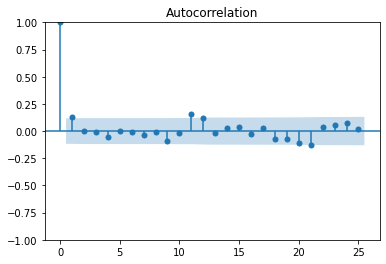

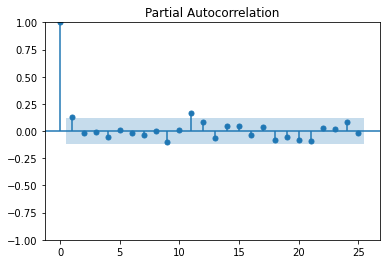

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(m_df['Diff'].dropna())
fig2=plot_pacf(m_df['Diff'].dropna())

The results from this ACF and PACF plot show interesting results. Beyond order = 0, there are not many order values that contribute significantly to prediction.

In [13]:
# seems lag should be 1 - test various values?
from statsmodels.tsa.ar_model import AutoReg as ar
res = ar(endog = ar_train_data['High'], lags = [1, 11]).fit()
# tested various values of lag (1, 3, 5, 10) - no significant accuracy change between values

Some of the values I tried were 1, 3, 5 and 10, all of which were contained in the ACF plot given above.

In [14]:
new_dates=[m_df.index[-1]+x for x in range(1, 21)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)

In [15]:
ar_df = pd.concat([m_df, df_pred])

This bit of code below creates our testing predictions

In [16]:
# start at the end of original data, go til the end of this new dataframe
ar_df['predictions']=res.predict(start=ar_train_data.shape[0], end=ar_df.shape[0])

The results of the plot show a reasonable close prediction for the next few days, but all the algorithm is doing is creating a flat line as its predictions

<AxesSubplot:>

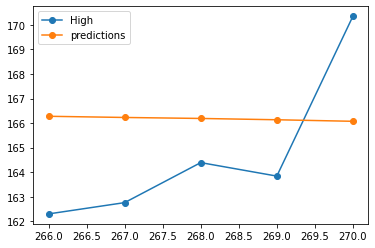

In [17]:
# High contrast plot of price versus predictions for future highs
plot_df = ar_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

The volatility of the stock data is likely responsible for the model's poor performance in predicting the future points.

In [18]:
# export model for dashboard
from joblib import dump
dump(res, 'stautoreg.model')

['stautoreg.model']

While the AR results were discouraging, I decided to press on and try a more complex model which extends upon the principles of autoregressive models

### ARIMA Model Creation

ARIMA Models elevate autoregressive models by incorporating difference and moving average information into the model. This creates a more complex but potentially more accurate model.

It appears from autocorrelation and part. autocorrelation plots that the values for p and q should be 1. d should also be 1 since we took the first difference to uncover the p and q values.

Using auto_arima function, we can find ARIMA model that minimizes AIC, a criteria for information loss

In [19]:
from pmdarima import auto_arima
auto_fit = auto_arima(ar_train_data['High'], max_p = 10, d = 1, trace=True, suppress_warnings=True, stepwise=False, max_order=15)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1125.840, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1124.874, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1126.846, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1128.753, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1130.244, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1131.944, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1124.861, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1126.855, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1128.836, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1130.626, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1132.100, Time=0.31 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=1133.940, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1126.852, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1128.750, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1128.464, Time=0.48 sec
 ARIMA(2,1

By these results, it recommends an ARIMA model with p = 0, d = 1 and q = 1, but the AIC results for all of these models are relatively close. As you will see from the plot below, they all gave poor model results

I decided to pick an ARIMA model with order (4, 1, 1) to demonstrate this

In [20]:
from statsmodels.tsa.arima.model import ARIMA
arima_mdl = ARIMA(endog=ar_train_data['High'], order=(4, 1, 1)).fit()
# Tried orders:
# (0, 1, 1) - best model as suggested by auto_arima function
# (10, 1, 1) - worked before training/testing split
# (5, 1, 4) - just experimenting to see if different values would cause *any* change at all
# no noticable change in any variation

Give summary of best fit model

In [21]:
arima_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  266
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -559.535
Date:                Thu, 17 Feb 2022   AIC                           1131.070
Time:                        10:53:12   BIC                           1152.549
Sample:                             0   HQIC                          1139.700
                                - 266                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2978      1.258     -0.237      0.813      -2.763       2.167
ar.L2          0.0451      0.141      0.319      0.750      -0.232       0.322
ar.L3         -0.0195      0.055     -0.357      0.721      -0.127       0.088
ar.L4         -0.0458      0.060     -0.769      0.442      -0.163       0.071
ma.L1          0.4080      1.248      0.327      0.744      -2.037       2.853
sigma2         3.9946      0.293     13.646      0.000       3.421       4.568
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                23.93
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.25
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Diagnostic Plots of Model

These plots show various diagnostics for the model we created. By all the plots here, we don't have any outstanding issues to address.

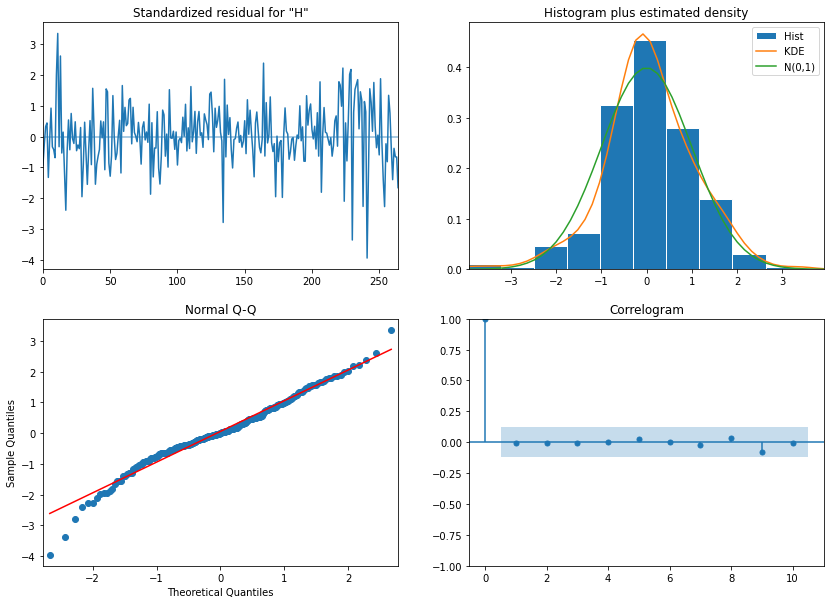

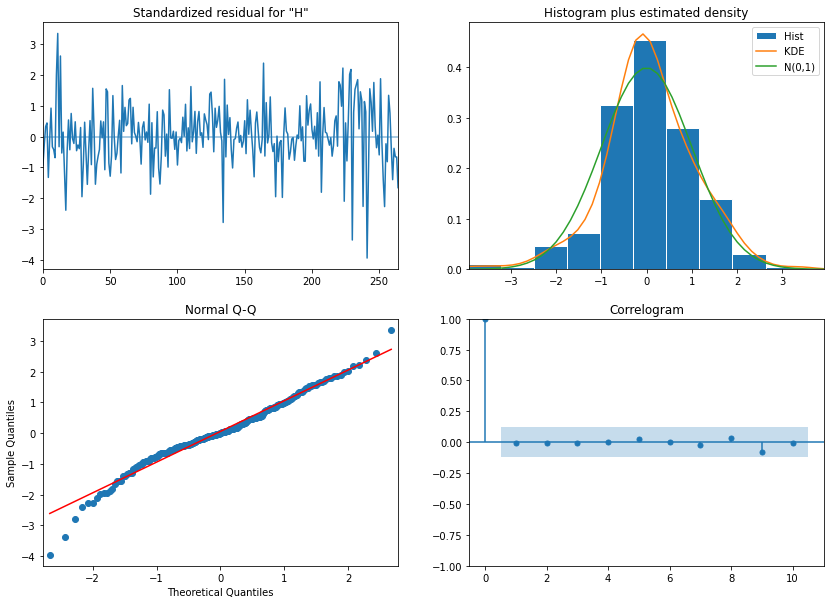

In [22]:
arima_mdl.plot_diagnostics(figsize = (14, 10))

In [23]:
new_dates=[m_df.index[-1]+x for x in range(1, 21)]
df_pred=pd.DataFrame(index=new_dates,columns=m_df.columns)
arima_df = pd.concat([m_df, df_pred])
arima_df['predictions']=arima_mdl.predict(start=ar_train_data.shape[0], end=arima_df.shape[0])

<AxesSubplot:>

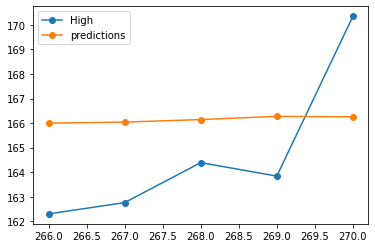

In [24]:
plot_df = arima_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

Like the AR model, the stock data presents a uniquely difficult challenge to the ARIMA model, which as we can see is not sure what to do and performs rather poorly

In [25]:
dump(arima_mdl, 'starima.model')

['starima.model']